# PSet 11: _The adventure of the 2001 dimensions_

In [1]:
# Importing useful modules + setting display options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_rows', 90)

## Question 1: reproduce Watsons's K-means result
Modify the K-means clustering procedure you wrote for Wiggins' data so that it works in 2001 dimensions, not just 2. Run a reasonable number of iterations (20-100, or even better, test for convergence), starting from several different initializations; report the lowest total squared distance (best clustering) you find for K=8. It should be close to what Watson found using k = 8 clusters, where his clustering achieved a sum of the squared distance = 87378.2. He used the "fixed" K-means method from part 3 of hw09, with his data represented as log counts.

***

We'll start by parsing through Watson's count data (200 single cell RNA-seq experiments and in tidy format, with each gene as a column and each observation/cell as a row)

In [2]:
# Parsing Watson's count data

data = pd.read_csv('w11-data.tbl', delim_whitespace=True) # Intake Watson's data
X = np.log(data + 1) # Log data since they are lognormally distributed. Add +1 to avoid taking log of 0.
N, G  = X.shape # Store dimensions: 200 rows (cells) and 2001 columns (genes)
X.head() # Display the first few rows of the log data

arugula  blueberry   cabbage  chickpea  clementine  cranberry  honeydew  \
0  5.332719   5.393628  6.278521  5.568345    5.683580   5.537334  6.794587   
1  6.023448   6.167516  6.171701  6.186209    5.424950   5.926926  7.182352   
2  5.332719   6.432940  6.797940  5.590987    6.410175   4.897840  7.269617   
3  4.564348   6.338594  6.946976  6.037871    5.204007   5.236442  5.945421   
4  5.501258   6.276643  6.226537  6.306275    6.287859   5.976351  6.813445   

   mulberry   mustard     onion  ...     H2BFS      PDXK  C21orf33      PFKL  \
0  5.370638  4.962845  5.123964  ...  3.784190  4.553877  6.270988  5.010635   
1  6.641182  4.912655  5.598422  ...  4.691348  4.844187  6.704414  5.159055   
2  5.713733  4.927254  6.246107  ...  4.644391  5.141664  6.070738  5.627621   
3  6.641182  4.564348  5.811141  ...  4.290459  4.709530  6.423247  6.037871   
4  6.115892  5.700444  6.177944  ...  4.859812  4.343805  6.543912  5.998937   

   KRTAP10-8   SLC19A1  SLC19A1.1  AC136352.2  AC136352.2.1  AL592183.1  
0   6.556778  6.675823   5.141664    5.278115      6.907755    6.226537  
1   7.232010  7.040536   5.241747    5.402677      6.175867    6.025866  
2   6.483107  6.831954   5.393628    6.282267      7.017506    6.154858  
3   6.925595  6.124683   5.220356    5.459586      7.734996    5.755742  
4   7.137278  5.666427   5.897154    4.955827      7.428333    6.052089  

[5 rows x 2001 columns]

**Note** : I dropped Pset 9 so I adapted (and commented) some code from the pset 9 answer key for this step.

The first step is to make a function that initializes a centroid by randomly sampling from a uniform distribution ranging from the minimum to the maximum value at each gene. We initialize one centroid at a time because we later use this function to reinitialize empty/orphan centroids in the iterations.

In [3]:
def initialize_centroid(rng, X):
    """
    Initialize a random centroid within the bounds of the data.

    Parameters:
        rng: Random number generator object.
        X: 2D numpy array (N, G) of data points, where N is the number of cells and G is the number of genes.

    Returns:
        numpy.ndarray: A 1D array of size G representing the randomly initialized centroid.
    """
    # Get the number of cells (N) and genes (G) from the data
    N, G = np.shape(X)
    
    # Determine the range (min and max values) for each gene (column)
    dmax = np.amax(X, axis=0)
    dmin = np.amin(X, axis=0)
    
    # Initialize centroid coordinates as zeros
    mu = np.zeros(G)
    
    # Sample a random value within the range for each gene
    for g in range(G):
        mu[g] = rng.uniform(dmin[g], dmax[g])
    
    return mu


Next, we need a function that calculates the Euclidean distance between a centroid and a datapoint (cell). This function does not need to log anything because the data has already been transformed into log space.

In [4]:
def euclidean_dist(v1, v2):
    """
    Compute the Euclidean distance between two vectors v1 and v2.

    Parameters:
        v1 (np.array): First vector.
        v2 (np.array): Second vector.

    Returns:
        float: The Euclidean distance ||v1 - v2||.
    """
    # Initialize the distance as zero
    d = 0.0

    # Compute the squared differences for each dimension (gene) and add it to the total distance (squared)
    for i in range(len(v1)):
        d += (v1[i] - v2[i])**2

    # Return the square root of the sum of squared differences: the actual Euclidean distance
    return np.sqrt(d)


Now, we need a function that will identify the current closest centroid to each datapoint (cell) at each K-means step by calculating the Euclidean distance beetween that datapoint and all the centroids.

In [5]:
def closest_centroid(x, centroids):
    """
    Find the closest centroid to a given data point.

    Parameters:
        centroids: 2D numpy.array (K, G) of centroid positions, where K is the number of centroids and G is the number of genes.
        x: 1D array of size G representing the coordinates of a single data point.

    Returns:
        best_k (int): Index of the closest centroid (0 to K-1).
        best_dist (float): Distance to the closest centroid.
    """
    # Number of centroids and dimensions (genes)
    K, dim = np.shape(centroids)

    # Start with the first centroid being the closest
    best_k = 0
    best_dist = euclidean_dist(x, centroids[0])

    # Check all other centroids and if they are closer than centroid 0, update best_k and best_dist
    for k in range(1, K):
        dist = euclidean_dist(x, centroids[k])
        if dist < best_dist: # If distance to centroid k is better than best_dist
            best_k = k        # Update the index of the closest centroid
            best_dist = dist  # Update the shortest distance

    return best_k, best_dist


Then, we need another function to implement the k-means assignment step (assigning each point to its closest centroid) using the closest_centroid() function.

In [6]:
def assign_kmeans(X, centroids):
    """
    Assign each data point to the nearest centroid and compute the total squared distance.

    Parameters:
        X: 2D numpy array (N, G) of data points, where N is the number of cells and G is the number of genes.
        centroids: 2D numpy array (K, G) of centroid positions, where K is the number of centroids.

    Returns:
        assignments: 1D numpy array (N,) where each entry is the index of the closest centroid for a data point.
        tot_sqdist (float): Total squared distance between all data points and their assigned centroids.
    """
    # Store the number of centroids (K) and genes (dim)
    K, dim = np.shape(centroids)

    # Store the number of data points
    N = len(X)

    # Initialize assignments array and total squared distance to zero
    assignments = np.zeros(N, dtype=int)
    tot_sqdist = 0

    # Assign each data point to the nearest centroid
    for i, x in enumerate(X):
        assignments[i], di = closest_centroid(x, centroids)  # Get closest centroid and distance for that point
        tot_sqdist += di**2  # Accumulate squared distance

    return assignments, tot_sqdist


Now, that we have assigned each data point to a centroid, we need a function to update the centroids based on that: calculate the new centroid positions, given assignments of data points to centroids.

We'll also watch out for the case where centroids may be empty (no assignments) to avoid division by zero.

In [7]:
def update_kmeans(rng, X, assignments, K):
    """
    Update the centroids based on current assignments and compute their frequencies.

    Parameters:
        rng: Random number generator object.
        X: 2D numpy array (N, G) of data points, where N is the number of cells and G is the number of genes.
        assignments: 1D numpy array (N,) where each entry is the index of the closest centroid for a data point.
        K (int): Number of centroids.

    Returns:
        centroids[k,g]: Updated centroids as a 2D array (K, G).
        pk[k]: Normalized frequencies (proportions) of points assigned to each centroid.
    """
    # Store number of data points (N) and genes (G)
    N, G = np.shape(X)

    # Initialize centroids and counts
    centroids = np.zeros((K, G))
    counts = np.zeros(K)

    # Accumulate sums of points assigned to each centroid
    for i in range(N):
        counts[assignments[i]] += 1 # Count how many points are assigned to each centroid.
        for g in range(G):
            centroids[assignments[i], g] += X[i, g] # Add up the coordinates across each gene in the points assigned to that centroid.

    # Compute centroids by dividing by the number of assigned points
    for k in range(K):
        if counts[k] > 0:  # Avoid division by zero if a centroid has no assigned points
            centroids[k] = centroids[k] / counts[k]
        else:  # If, centroid has no assigned points, reinitialize empty centroids randomly
            centroids[k] = initialize_centroid(rng, X)

    # Normalize counts to get frequencies
    pk = counts / np.sum(counts)

    return centroids, pk


Last but not least, we need a way of checking whether the iterative algorithm has converged. One way to do that is to check whether any assignments were changed in the current iteration compared to the previous one. If there are no changes in assignments, we have likely reached a stable answer and can stop iterating.

In [8]:
def diff_assignments(a1, a2):
    """
    Count the number of differing cluster assignments between two arrays a1 and a2.

    Parameters:
        a1: 1D array of cluster assignments of size N (number of data points) (a1[i] = 0..K-1, a cluster assignment)
        a2: 1D array of cluster assignments of size N (number of data points).

    Returns:
        ndiff (int): Number of positions where assignments differ between `a1` and `a2`.
    """
    # Initialize count of differing assignments as zero
    ndiff = 0

    # Compare each pair of assignments
    for i in range(len(a1)):
        if a1[i] != a2[i]:
            ndiff += 1 # If a pair is difference, increment ndiff by 1

    return ndiff


Now, we'll finally implement the k-means algorithm itself, using all of the functions above. We'll have the k-means function iterate till it converges, and then return kp (the probability mass assigned to a centroid), centroids (their coordinates in gene space), assignments (which centroid each data point is assigned to), tot_sqdist (total squared Euclidean distance for this k-means solution), n_iterations (how many iterations the algorithm took to converge).

Since k-means is a local optimizer, we'll actually run the k-means algorithm 20 times and choose the best answer with the lowest tot_sqdist.

In [9]:
def kmeans(rng, X, K):
    """
    Perform K-means clustering on the data.

    Parameters:
        rng: Random number generator object.
        X: 2D numpy array (N, G) of data points, where N is the number of cells and G is the number of genes.
        K (int): Number of centroids.

    Returns:
        kp (1D numpy array): Normalized cluster frequencies (proportion of points in each cluster) of size K.
        centroids (2D numpy array): Final centroid positions as a 2D array (K, G).
        assignments (1D numpy array): Final cluster assignments for each data point (N,).
        tot_sqdist (float): Total squared Euclidean distance (K-means objective function value).
        n_iterations (int): Number of iterations until convergence.
    """
    # Store number of cells (N) and genes (G)
    N, G = np.shape(X)

    # Initialize centroids randomly
    centroids = np.zeros((K, G))
    for k in range(K):
        centroids[k] = initialize_centroid(rng, X)

    # Initialize number of iterations as zero
    n_iterations = 0
    while True:
        # Assign data points to the closest centroids
        assignments, tot_sqdist = assign_kmeans(X, centroids)

        # Check for convergence (if no changes in assignments, break)
        if n_iterations >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff == 0:
                break

        # Update centroids based on current assignments
        centroids, kp = update_kmeans(rng, X, assignments, K)
        old_assignments = assignments
        n_iterations += 1

    # Count and normalize cluster frequencies (proportions of points in each cluster)
    kp = np.zeros(K)
    for i in range(N):
        kp[assignments[i]] += 1
    kp = kp / N

    return kp, centroids, assignments, tot_sqdist, n_iterations


Now, let's run 20 times!

In [10]:
X = np.array(X) # Make sure the data array is in numpy.array format
K = 8 # Look for 8 clusters

# Initialize results array
results = []

# Run 20 times
for run in range(20): 
    rng = np.random.default_rng(run)   # Use the run number as the fixed seed
    kp, centroids, assignments, tot_sqdist, n_iter = kmeans(rng, X, K) # Run K-means
    results.append((run, kp, centroids, assignments, tot_sqdist, n_iter)) # Append results 
    
# Print results: run, number of iterations, total squared distance for that run 
for r in results:
    run, n_iter, tot_sqdist = r[0], r[5], r[4]
    print('{:2d} {:4d} {:10.2f}'.format(run, n_iter, tot_sqdist))

 0    3   89717.67
 1    7   88182.03
 2    8   88375.86
 3    1   91031.08
 4   11   87752.26
 5    3   89096.11
 6    9   88057.32
 7    6   88410.93
 8    6   88047.03
 9    8   88185.98
10    5   87606.23
11    5   88687.91
12    5   88416.52
13    6   87737.33
14    7   88790.58
15   15   87782.33
16    7   87934.19
17    8   88019.07
18    1   92188.42
19    5   88259.24


The best run (with the lowest squared distance) is run 10 with a total squared distance of 87606.23 so we'll use the assignments from that run later on to show how well k-means clustering performs.

In [11]:
# Print the assignments we'll use later to show K-means clustering
results[10][3]

array([1, 1, 3, 2, 2, 3, 1, 3, 2, 1, 3, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2,
       2, 2, 1, 1, 2, 3, 2, 3, 1, 3, 1, 3, 2, 3, 1, 2, 1, 2, 1, 1, 3, 1,
       1, 2, 3, 5, 3, 1, 2, 2, 3, 3, 5, 1, 2, 3, 3, 2, 1, 1, 5, 2, 1, 2,
       3, 1, 1, 2, 2, 2, 3, 2, 3, 3, 3, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1,
       3, 3, 3, 2, 1, 4, 2, 1, 3, 1, 1, 3, 2, 1, 2, 1, 2, 1, 2, 1, 3, 2,
       1, 3, 1, 2, 3, 1, 3, 3, 2, 2, 3, 1, 1, 1, 3, 2, 2, 3, 1, 1, 1, 2,
       1, 1, 3, 1, 1, 3, 4, 3, 1, 2, 3, 1, 3, 0, 1, 3, 3, 3, 2, 2, 1, 0,
       0, 3, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 3, 2, 2, 3, 1, 3, 1, 3, 1, 2,
       2, 2, 6, 2, 1, 2, 3, 2, 3, 3, 2, 2, 1, 2, 1, 3, 1, 3, 2, 1, 1, 1,
       1, 2])

## Question 2: reduce the dimensionality
Write a Python function that uses singular value decomposition to find the principal components of the data set.

Plot all 200 cells in 2D expression space using their projections onto the first two principal axes. Was Watson right to expect 8 clusters? 

Plot the eigenvalues for each component, and justify why you're pretty sure it would be hard to find any other clusters in the data set. The eigenvalues from a simulated negative control data set, where there were no cell types and no correlations between any of the genes, should factor into your answer.

Based on the eigenvector loadings, how many genes appear to influence cell type identity? Explain.

***

In [12]:
# SVD Analysis

# Center data matrix first
column_means = np.mean(X, axis = 0) # Obtain the column_means of X (array of 2001)
X_centered = X - column_means # Center X by subtracting the column means from the columns

# SVD
U, S, W_t = np.linalg.svd(X_centered)

# Check dimensions to make sure it worked
print("U dimensions" + str(U.shape))
print("S dimensions" + str(S.shape))
print("W_t dimensions" + str(W_t.shape))

#Check if the trace of the eigenvalues vector is equal to the total variance in the data.

# Calculating eigenvalues
eigenvalues = np.square(S) / (N - 1) # Sigma = S^2 / (N-1)

# Total variance from eigenvalues
sum_eigenvalues = np.sum(eigenvalues)

# Total variance directly from the centered matrix
total_var = np.sum(np.var(X_centered, axis=0, ddof=1))  # ddof=1 for sample variance

# Compare the two
print(f"Sum of eigenvalues: {sum_eigenvalues}")
print(f"Total variance from centered data matrix: {total_var}")

U dimensions(200, 200)
S dimensions(200,)
W_t dimensions(2001, 2001)
Sum of eigenvalues: 475.3974555686973
Total variance from centered data matrix: 475.39745556869707


As expected, the sum of eigenvalues is equal to the total variance from the the data matrix. 

Now, we want to plot all 200 cells in 2D PCA space using their projections onto the first two principal axes. We'll use the following equation to get the cells in 2D PCA space:

$$Y_q^* = X^* W_q $$

(200, 2)


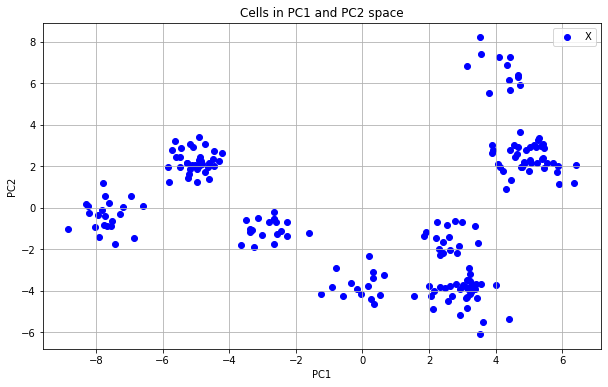

In [13]:
# Plot cells in 2D PCA space using their projections onto the first two PC axes

# Extract the loadings of each gene for PC1 and PC2
Wq = W_t.T[:, 0:2]  # Take the first two columns (PC1 and PC2 loadings) after transposing W_t

# Project the centered data X_centered onto PC1 and PC2
Yq = X_centered @ Wq  # This equation gives the projections in PC1-PC2 space
print(Yq.shape)  # Check the shape of the projections (should be 200x2)

# Plotting the projections of cells in the 2D PCA space
plt.figure(figsize=(10, 6))  # Create a figure
plt.scatter(Yq[:, 0], Yq[:, 1], label="X", color='blue', marker='o')  # Scatter plot for PC1 vs. PC2
plt.xlabel('PC1')  # Label for the x-axis (PC1)
plt.ylabel('PC2')  # Label for the y-axis (PC2)
plt.title('Cells in PC1 and PC2 space')  # Title of the plot
plt.legend()  # Add a legend to the plot
plt.grid(True)  # Enable grid lines for better readability
plt.show()  # Display the plot


Was Watson right to expect 8 clusters?

Yes, Watson was right to expect 8 clusters. When we plot the data in PC-space projections, we clearly see 8 clusters form.

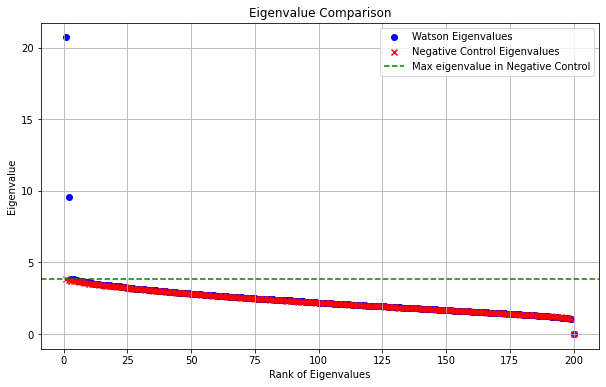

In [14]:
# Plot eigenvalues for each component, comparing to negative controls

# Read negative control eigenvalues from file
eigenvalues_negcontrol = []
with open('w11-eigen.tbl', 'r') as file:
    for line in file:
        _, value = line.split()  # Extract eigenvalue from each line
        eigenvalues_negcontrol.append(float(value)) # Append eigenvalue to eigenvalues array

# Append 0 to ensure 200 values (neg control data has 199 values but the resulting eigenvalues from SVD analysis have 200)
eigenvalues_negcontrol.append(0)
eigenvalues_negcontrol = np.array(eigenvalues_negcontrol)  # Convert list to NumPy array
max_negcontrol = np.max(eigenvalues_negcontrol)  # Get the max eigenvalue in the negative control to plot later

# Create rank for plotting eigenvalues
rank = np.arange(1, len(eigenvalues) + 1)

# Plot eigenvalues
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(rank, eigenvalues, label="Watson Eigenvalues", color='blue', marker='o')  # Plot Watson eigenvalues
plt.scatter(rank, eigenvalues_negcontrol, label="Negative Control Eigenvalues", color='red', marker='x')  # Plot negative control eigenvalues
plt.axhline(y=max_negcontrol, color='green', linestyle='--', label='Max eigenvalue in Negative Control')  # Add a threshold line
plt.xlabel('Rank of Eigenvalues')  # Label x-axis
plt.ylabel('Eigenvalue')  # Label y-axis
plt.title('Eigenvalue Comparison')  # Add title
plt.legend()  # Add legend to distinguish data sets
plt.grid(True)  # Enable grid for better readability
plt.show()  # Display the plot


Given the eigenvalues plot, I'm pretty sure it would be hard to find any other clusters in the dataset because only the first two PCs have eigenvalues higher than background noise (negative control eigenvalues), so they are the 2 components with the most information. Given that when we plot all the cells projected onto these two principal components, we only see 8 clusters, and that the other principal components are unlikely to carry much more significant information, we can be pretty sure that there are only 8 clusters in the dataset.

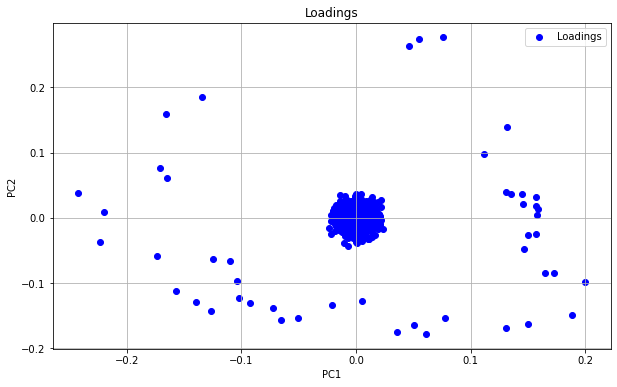

In [15]:
# Examine eigenvector loadings to determine the influence of genes on cell type identity

# Plot the loadings for the first two principal components (PC1 and PC2)
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(W_t[0], W_t[1], label="Loadings", color='blue', marker='o')  # Plot PC1 vs. PC2 loadings
plt.xlabel('PC1')  # Label for the x-axis (PC1)
plt.ylabel('PC2')  # Label for the y-axis (PC2)
plt.title('Loadings')  # Add title to the plot
plt.legend()  # Add a legend to describe the data
plt.grid(True)  # Enable grid for easier interpretation
plt.show()  # Display the plot


Based on the plot above, I am setting 0.1 as a loading boundary for gene significance since all the genes that have significant influence on cell type identity are far away from the origin and there seems to be a natural gap in the plot around 0.1. 

In [16]:
# Calculate the exact number of genes that significantly influence cell type identity using the borders of 0.1
condition = ((W_t[0] <= -0.1) | (W_t[0] >= 0.1)) | ((W_t[1] <= -0.1) | (W_t[1] >= 0.1))

# Get indices satisfying the condition
indices = np.where(condition)[0]

# Print how many genes significantly influence cell type identity using the borders of 0.1
print(len(indices))


47


Based on the eigenvector loadings, the number of genes appearing to influence cell type identity is 47 since genes that have a large impact on cell type identity would be far away from the origin on the previous loadings plot.

## Question 3: check the clustering
Plot the data in 2D principal component space, and color each point according to the cluster identities from part 1. You should find that K-means is missing the mark.

Offer an explanation of what might be going wrong, and find a way to cluster so that each cell appears properly assigned in PC space.

***

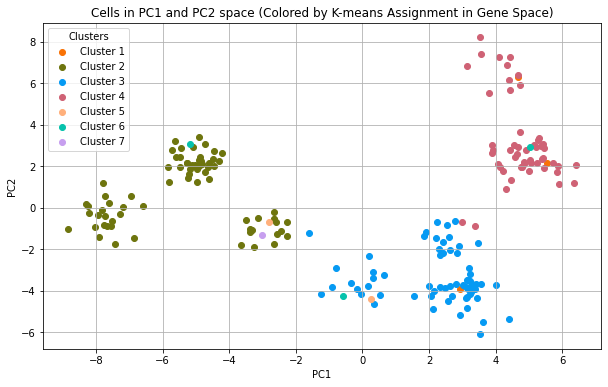

In [17]:
# Color cells by K-means clustering assignments

# Use the assignments from the 10th K-means run (lowest total squared distance)
assignments = results[10][3]

# Initialize the plot
plt.figure(figsize=(10, 6))  # Create figure and set its size

# Define a colormap for up to 8 clusters
colormap = ['xkcd:orange', 'xkcd:olive', 'xkcd:azure', 'xkcd:rose', 
            'xkcd:peach', 'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust']

# Plot cells for each cluster using the unique cluster assignments
for cluster in np.unique(assignments):
    cluster_indices = np.where(assignments == cluster)  # Get indices for this cluster
    plt.scatter(Yq[cluster_indices, 0], Yq[cluster_indices, 1],  # Plot cells in PC1-PC2 space
                color=colormap[cluster], label=f"Cluster {cluster+1}", marker='o')

# Add axis labels, title, and legend
plt.xlabel('PC1')  # Label for the x-axis
plt.ylabel('PC2')  # Label for the y-axis
plt.title('Cells in PC1 and PC2 space (Colored by K-means Assignment in Gene Space)')  # Title of the plot
plt.legend(title="Clusters")  # Add legend with a title
plt.grid(True)  # Enable grid lines for better readability
plt.show()  # Display the plot


Clearly, K-means is missing the mark. The clusters are not correctly identified through the K-means algorithm with noisy data. The K-means algorithm is getting too bogged down in the noise in the non-significant dimensions. There are 2001 genes and only about 47 of them really affect cell type identity but the K-means algorithm cannot parse the signal from noise because there's too much background noise. To avoid this, we'll run the K-menas algorithm on data projected onto the PC space (using the cells' projections onto the first two principal axes) instead. The K-means algorithm should have an easier time identifying the clusters in PC space (with all the noisy dimensions gone).

In [18]:
# Fix it by running k-means in PC-space
K = 8 # Look for 8 clusters

# Initialize results array
results_new = []

# Run 20 times
for run in range(20): 
    rng = np.random.default_rng(run)   # Use the run number as the fixed seed
    kp, centroids, assignments, tot_sqdist, n_iter = kmeans(rng, Yq, K) # Run K-means in PC space
    results_new.append((run, kp, centroids, assignments, tot_sqdist, n_iter)) # Append results 
    
# Print results: run, number of iterations, total squared distance for that run 
for r in results_new:
    run, n_iter, tot_sqdist = r[0], r[5], r[4]
    print('{:2d} {:4d} {:10.2f}'.format(run, n_iter, tot_sqdist))

 0    7     221.12
 1   10     220.94
 2    5     209.48
 3    5     204.81
 4    9     307.82
 5    6     129.71
 6    8     221.19
 7    7     205.84
 8    5     205.84
 9    7     304.36
10    7     129.71
11    5     300.02
12    6     299.26
13    5     206.23
14    4     129.71
15    8     205.62
16    4     129.71
17    9     200.63
18   12     129.71
19    5     208.81


The best run (with the lowest squared distance) is run 5 with a total squared distance of 129.71 so we'll use the assignments from that run to show how well k-means clustering performs on data projected in PC space.

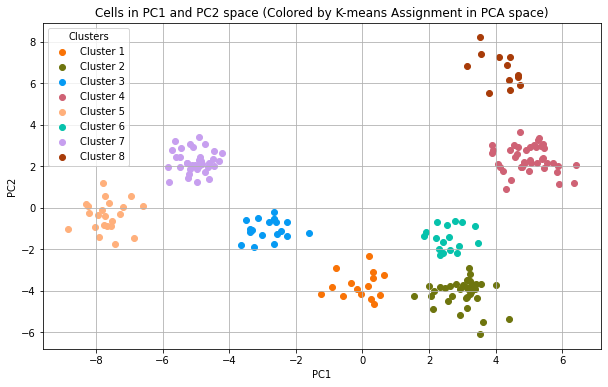

In [19]:
# Color cells by K-means clustering assignments on data projected into PCA space!

# Use the assignments from the 10th K-means run (lowest total squared distance)
assignments = results_new[10][3]

# Initialize the plot
plt.figure(figsize=(10, 6))  # Create figure and set its size

# Define a colormap for up to 8 clusters
colormap = ['xkcd:orange', 'xkcd:olive', 'xkcd:azure', 'xkcd:rose', 
            'xkcd:peach', 'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust']

# Plot cells for each cluster using the unique cluster assignments
for cluster in np.unique(assignments):
    cluster_indices = np.where(assignments == cluster)  # Get indices for this cluster
    plt.scatter(Yq[cluster_indices, 0], Yq[cluster_indices, 1],  # Plot cells in PC1-PC2 space
                color=colormap[cluster], label=f"Cluster {cluster+1}", marker='o')

# Add axis labels, title, and legend
plt.xlabel('PC1')  # Label for the x-axis
plt.ylabel('PC2')  # Label for the y-axis
plt.title('Cells in PC1 and PC2 space (Colored by K-means Assignment in PCA space)')  # Title of the plot
plt.legend(title="Clusters")  # Add legend with a title
plt.grid(True)  # Enable grid lines for better readability
plt.show()  # Display the plot

And clearly, The K-means algorithm, as expected, has a much easier time identifying the clusters when the data is projected into PC space because the noisy dimensions are gone! The 8 clusters are all correctly identified.

## Question 4: reconstruct the expression patterns
Reconstruct the original data set using only the projected data and eigenvectors for the first 2 principal components. Visualize the data using a heat map. Do the clusters now look more obvious? Why or why not?


***

To reconstruct the original dataset using only the projected data and eigenvectors for the first 2 principal components, we will use the following equation:

$$\hat{X^*} = Y_q^* W^T_q  $$

In [20]:
# Reconstruct and visualize the original dataset using the first two principal components

# Step 1: Sort data points by their cluster assignments (to visualize the different between clusters better)

# Obtain indices to reorder data points based on their cluster assignments (from the 10th K-means run)
sorted_indices = np.argsort(assignments)

# Reorder the rows of the projected data (`Yq`) using the sorted indices
Yq_clustered = Yq[sorted_indices]

# Step 2: Reconstruct the dataset using only the first two principal components
X_new = Yq_clustered @ Wq.T
print(X_new.shape)  # Check the shape of the reconstructed dataset

(200, 2001)


The shape is (200,2001) just like the original dataset, as expected.

<AxesSubplot:>

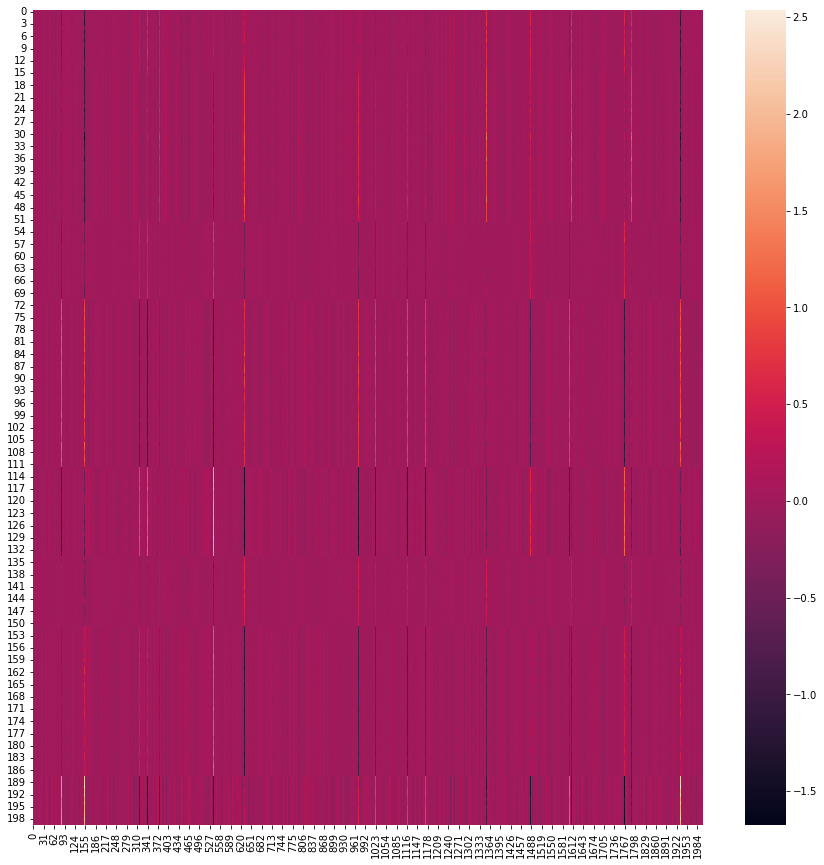

In [21]:
# Step 3: Visualize the original dataset as a heatmap using the first two principal components

plt.figure(figsize=[15, 15])  # Set a large figure size for better visibility
sns.heatmap(X_new, vmin=X_new.min(), vmax=X_new.max())  # Plot a heatmap of the filtered data

You can kind of make out differences between the clusters but this is not a good visualization because there is still too much noise! Too many genes (the vase majority of the 2001 genes) where there are no notable differences between the different clusters because those genes do not influence cell type identity. Let's try and limit our heatmap to only show the 47 genes that we early identified (using PCA loadings) to impact cell type identity:

(200, 47)


<AxesSubplot:>

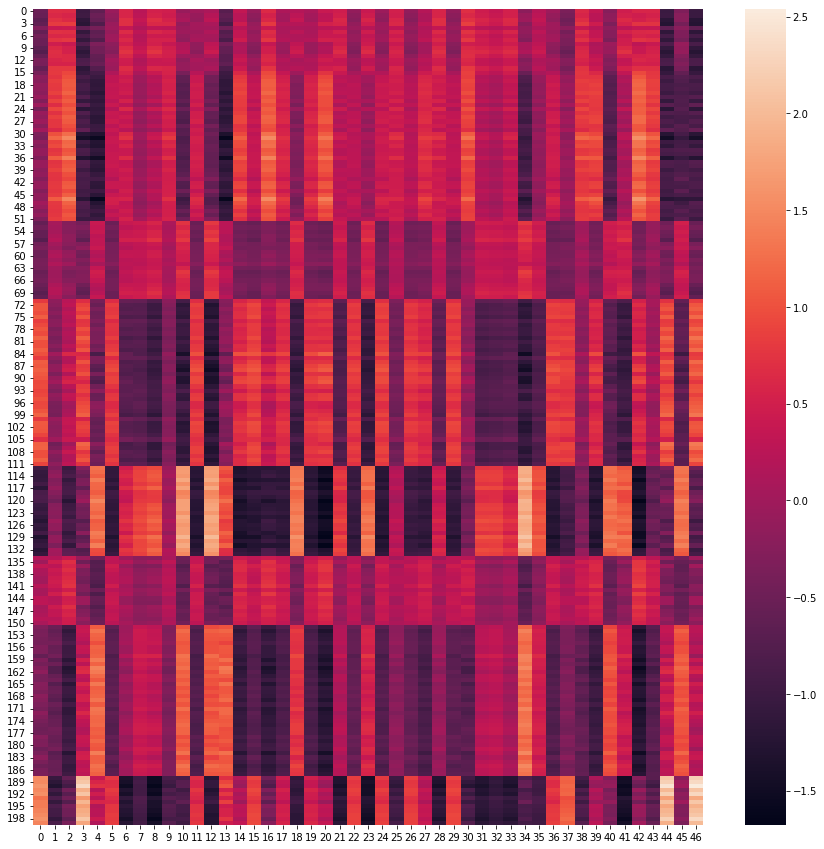

In [22]:
# Step 4: Filter reconstructed data to include only the influential gene indices
X_filtered = X_new[:, indices]
print(X_filtered.shape)  # Check the shape of the filtered dataset

# Step 5: Visualize the filtered dataset as a heatmap
plt.figure(figsize=[15, 15])  # Set a large figure size for better visibility
sns.heatmap(X_filtered, vmin=X_filtered.min(), vmax=X_filtered.max())  # Plot a heatmap of the filtered data


Now, we can see much more clearly the differences in gene expression profiles between the different cell types/clusters. The clusters look much more obvious now because we've denoised the data by transforming it into PCA space, removing the noisy dimensions (non-influential genes), and transforming it back into gene space. Now, just plotting the data as a heatmap using the influential genes is enough to see the different gene expression patterns in the different clusters easily because there isn't as much noise. 

***

In [23]:
import watermark 
%load_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab


Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

numpy     : 1.21.5
matplotlib: 3.5.1
seaborn   : 0.11.2
pandas    : 1.4.2
jupyterlab: 3.3.2

Compiler    : Clang 12.0.0 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

